In [1]:
# import the necessary packages
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os

from matplotlib import pyplot
from matplotlib.patches import Rectangle


%matplotlib inline

Using TensorFlow backend.


In [2]:
#inherting  from Config class
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_inference"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background
    # but the background class is *already* included in the class
    # names)
    NUM_CLASSES = 1+80

In [3]:
# creatig an instance
config = myMaskRCNNConfig()

In [4]:
# initialize the Mask R-CNN model for inference 
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')

Loading Mask R-CNN model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
#n load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

In [6]:
os.getcwd()


'C:\\Users\\khandelwalr\\Mask_RCNN'

In [7]:
# define 81 classes that the coco model knowns about along with back ground
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

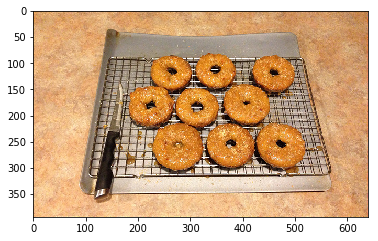

In [8]:
# load the image into a numpy array and show the original image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
img = load_img('donuts.jpg')
#pyplot.imshow(img)
img = img_to_array(img)
pyplot.imshow(img/255)

In [9]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=5)
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

In [10]:
# make prediction
results = model.detect([img], verbose=0)

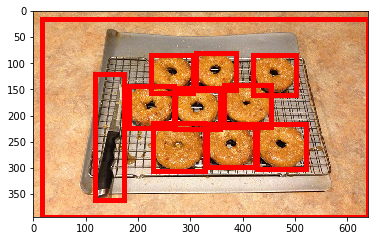

In [11]:
# visualize the results
draw_image_with_boxes('donuts.jpg', results[0]['rois'])

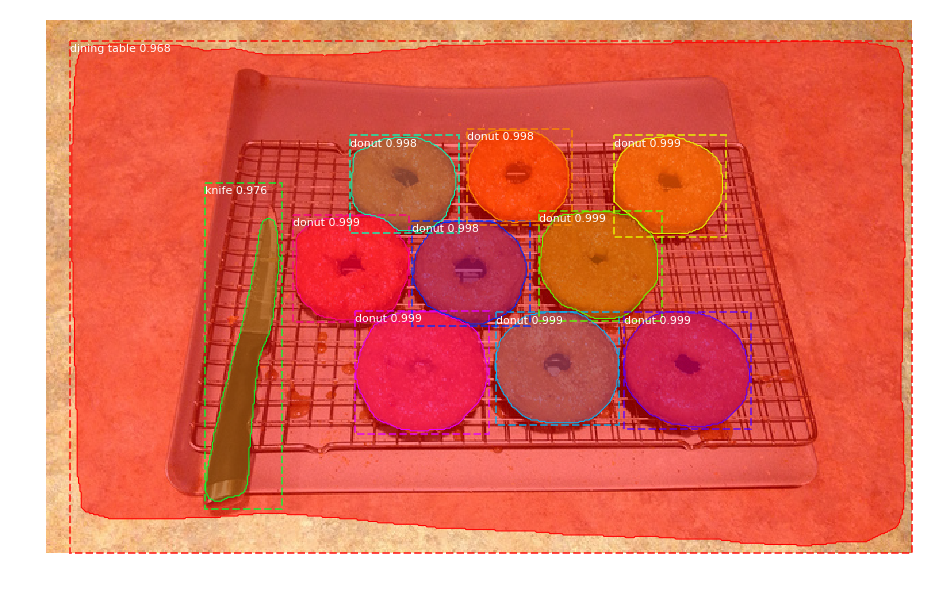

In [12]:
# get dictionary for first prediction
from mrcnn.visualize import display_instances
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [13]:
# Generate Anchors
from mrcnn import utils
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


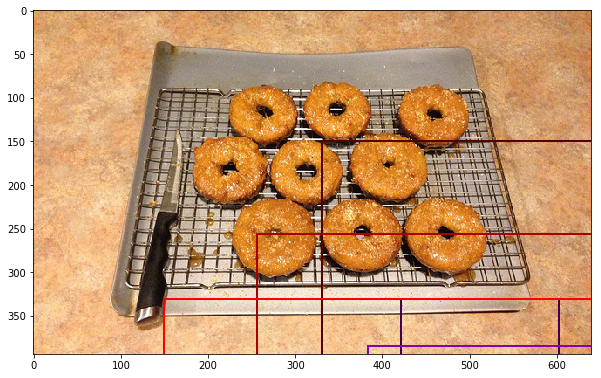

In [14]:

## Visualize anchors of one cell at the center of the feature map of a specific level
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
# Load and draw random image
#image_id = np.random.choice(dataset.image_ids, 1)[0]
#image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
image = load_img('donuts.jpg')
image = img_to_array(image)
fig, ax = pyplot.subplots(1, figsize=(10, 10))
ax.imshow(image/255)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)